# LDA with Highlights

## Imports

In [15]:
import collections
import joblib
import pathlib
import pprint

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
import ipywidgets

from bbcov import LDAModel, Embedder, QueryMachine

## Data

In [2]:
path_syn = '/raid/covid19_kaggle-data/synonyms_list.txt'
path_data = "../../preproccessed_data/v4_json_metadata_v2.pkl"

df_docs = pd.read_pickle(path_data)
df_docs = df_docs[:500]

with open(path_syn, 'r') as f:
    raw = f.read()

## Synonyms

In [3]:
# Put synonyms to list of lists
final_list = []
for line in raw[1:].split('\n'):
    if line:
        final_list.append([])
        for word in line.split('='):
            final_list[-1].append(word.replace(' ', '').lower())

# main keyword to set of synonyms mapping
dict_synonyms = {group[0]: set(group[1:]) for group in final_list}

# synonyms to main keyword mapping
dict_inv = {}

for k, v in dict_synonyms.items():
    for word in v:
        dict_inv[word] = k
        

# text replacer of synonyms
def tform(x, verbose=False):
    """
    Parameters
    ----------
    x : str
        An input text.
    """
    
    tokens = x.split(' ')
    
    new_tokens = []
    counter = 0
    for i, token in enumerate(tokens):
        try:
            new_token = dict_inv[token.lower()]
            counter += 1
        except KeyError:
            new_token = token
        
        new_tokens.append(new_token)
    
    if verbose:
        print(counter)

    return ' '.join(new_tokens)

In [18]:
pprint.pprint(dict_synonyms)

{'chloroquine': {'cq', 'hydroxychloroquine', 'hq'},
 'coronavirus': {'hcov-229e',
                 'hcov-hku1',
                 'hcov-nl63',
                 'hcov-oc43',
                 'ibv',
                 'mers',
                 'mers-cov',
                 'mhv',
                 'phev',
                 'sars',
                 'sars-cov-1',
                 'sars-cov-2',
                 'tgev',
                 'thev'},
 'glucoseloweringdrugs': {'acarbose',
                          'gliflozin',
                          'gliptin',
                          'metformin',
                          'miglitol'},
 'glucosetransportinhibitor': {'wzb117', 'cytochalasineb'},
 'glycosylation': {'glycans',
                   'high-mannose',
                   'n-glycans',
                   'n-glycoproteins',
                   'n-glycosylation',
                   'oligomannose'},
 'level': {'concentration'},
 'riskfactor': {'predictionfactor', 'susceptibilityfactor', 'severity'},


In [16]:
pprint.pprint(dict_inv)

{'acarbose': 'glucoseloweringdrugs',
 'acuterespiratorydistresssyndrome': 'sars',
 'ards': 'sars',
 'carbohydrates': 'sugar',
 'concentration': 'level',
 'cq': 'chloroquine',
 'cytochalasineb': 'glucosetransportinhibitor',
 'gliflozin': 'glucoseloweringdrugs',
 'gliptin': 'glucoseloweringdrugs',
 'glucose': 'sugar',
 'glycans': 'glycosylation',
 'hcov-229e': 'coronavirus',
 'hcov-hku1': 'coronavirus',
 'hcov-nl63': 'coronavirus',
 'hcov-oc43': 'coronavirus',
 'high-mannose': 'glycosylation',
 'hq': 'chloroquine',
 'hydroxychloroquine': 'chloroquine',
 'ibv': 'coronavirus',
 'mers': 'coronavirus',
 'mers-cov': 'coronavirus',
 'metformin': 'glucoseloweringdrugs',
 'mhv': 'coronavirus',
 'miglitol': 'glucoseloweringdrugs',
 'n-glycans': 'glycosylation',
 'n-glycoproteins': 'glycosylation',
 'n-glycosylation': 'glycosylation',
 'oligomannose': 'glycosylation',
 'phev': 'coronavirus',
 'pneumonia': 'sars',
 'predictionfactor': 'riskfactor',
 'respiratoryfailure': 'sars',
 'sars': 'coronavir

In [4]:
# add to the original dataframe
df_docs['tformed_text'] = df_docs['text'].apply(lambda x: tform(x, verbose=True))

1
14
1
0
0
1
7
9
0
0
0
1
1
3
19
0
1
2
2
0
10
0
19
5
0
0
78
0
1
1
3
2
0
2
2
1
40
8
6
11
1
23
31
17
0
17
0
1
1
1
6
1
7
2
4
0
4
2
7
0
120
7
0
1
0
0
0
1
1
14
7
20
11
311
0
15
6
5
12
9
0
0
1
7
0
7
3
14
0
8
69
74
6
0
1
0
20
0
4
0
0
6
23
3
1
0
19
2
0
6
41
10
0
0
2
4
0
0
2
11
174
2
58
6
0
6
2
3
30
2
0
0
0
56
2
1
0
1
14
0
2
0
17
2
74
17
4
1
12
7
3
5
0
0
1
1
4
6
1
4
0
28
56
0
43
16
79
22
10
2
1
8
6
2
4
3
1
16
1
20
43
2
5
0
4
2
1
7
9
3
3
7
0
0
1
0
23
1
0
0
0
18
28
1
1
0
1
0
6
5
1
0
19
2
0
2
11
68
0
0
1
2
10
25
2
1
3
17
18
1
1
0
3
0
0
0
44
5
0
1
1
0
1
6
3
7
47
1
9
1
5
80
1
0
1
2
1
5
2
85
4
0
0
11
2
26
26
0
11
2
4
4
6
4
0
6
0
6
1
0
8
4
3
46
2
1
3
0
14
5
0
0
2
3
7
0
0
9
0
2
2
0
40
0
2
4
0
1
1
2
0
0
1
0
0
6
4
0
40
4
26
0
2
0
0
1
3
0
0
1
0
3
0
19
0
15
1
6
0
7
1
4
15
1
2
1
0
0
0
1
0
0
9
1
33
3
11
0
0
1
1
2
0
2
6
0
7
6
4
4
0
3
3
8
0
0
0
4
4
1
35
1
0
3
1
3
2
8
28
2
0
146
0
0
11
6
8
1
3
0
0
3
3
26
3
4
84
2
0
16
0
0
7
2
0
0
1
0
0
8
4
0
0
6
0
15
0
3
7
0
5
0
9
18
0
8
27
3
5
2
2
10
87
44
19
0
0
0
89
1
0
3
4
3

## LDA Model

In [5]:
import en_core_sci_md

nlp = en_core_sci_md.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2_000_000  # maximal number of characters in text

In [6]:
def spacy_tokenizer(sentence):
    return [token.lemma_ for token in nlp(sentence) if not (
        token.like_url or
        token.like_email or
        token.like_num or
        token.is_stop or
        token.is_punct or
        token.is_space or
        token.is_bracket or
        token.is_punct or
        len(token)==1)]

In [7]:
vectorizer = joblib.load('../../stan/1_topic_modeling_lda/tf_vectorizer.csv')
lda = joblib.load('../../stan/1_topic_modeling_lda/lda.csv')

In [8]:
lda_model = LDAModel(vectorizer, lda)
lda_embedder = Embedder(lda_model)

In [9]:
query_machine_original = QueryMachine(lda_embedder, df_docs, 'text', jensenshannon)
query_machine_synonyms = QueryMachine(lda_embedder, df_docs, 'tformed_text', jensenshannon)

## Create Query Widget with Exclusions

In [10]:
min_year = df_docs.publish_time.min().year
max_year = df_docs.publish_time.max().year
word_counts = df_docs.text.apply(lambda x: len(x.split()))
min_word_count = word_counts.min()
max_word_count = word_counts.max()

@ipywidgets.interact(
    has_title=ipywidgets.Checkbox(
        description="Require Title",
        value=True),
    has_authors=ipywidgets.Checkbox(
        description="Require Authors",
        value=True),
    has_abstract=ipywidgets.Checkbox(
        description="Require Abstract",
        value=False),
    has_journal=ipywidgets.Checkbox(
        description="Require Journal",
        value=False),
    has_doi=ipywidgets.Checkbox(
        description="Require DOI",
        value=False),
    date_range=ipywidgets.IntRangeSlider(
        description="Date Range:",
        continuous_update=False,
        min=min_year,
        max=max_year,
        value=(min_year, max_year),
        layout=ipywidgets.Layout(width='80ch')),
    word_count_range=ipywidgets.IntRangeSlider(
        description="Text Word Count Range:",
        continuous_update=False,
        min=min_word_count,
        max=max_word_count,
        value=(min_word_count, max_word_count),
        style={'description_width': '20ch'},
        layout=ipywidgets.Layout(width='80ch')),
    k=ipywidgets.IntSlider(
        description="Top k:",
        value=3,
        min=1,
        max=30,
        continuous_update=False),
    text=ipywidgets.Textarea(
        description="Query:",
        value="cure for covid-19",
        continuous_update=False,
        layout=ipywidgets.Layout(width='80ch', height='200px')),
    exclusions=ipywidgets.Textarea(
        description="Excluded Phrase:",
        value="",
        continuous_update=False,
        style={'description_width': '30ch'},
        layout=ipywidgets.Layout(width='50ch', height='200px')),
    button=ipywidgets.ToggleButton(description="Submit"),
    use_synonyms=ipywidgets.Checkbox(value=False, description='Use synonyms')
)
def _(k, date_range, word_count_range, has_title,
      has_authors, has_abstract, has_journal, has_doi, text,
       exclusions, button, use_synonyms):
    # Year filter
    from_year = pd.Timestamp(year=date_range[0], month=1, day=1)
    to_year = pd.Timestamp(year=date_range[1], month=12, day=31)
    mask = df_docs.publish_time.between(from_year, to_year)
    
    # Word counts
    mask &= word_counts.between(*word_count_range)
    
    if has_title:
        mask &= ~(df_docs.title.isna() | (df_docs.title == ''))
        
    if has_authors:
        mask &= ~(df_docs.authors.isna() | (df_docs.authors == ''))
    
    if has_abstract:
        mask &= ~(df_docs.abstract.isna() | (df_docs.abstract == ''))
        
    if has_journal:
        mask &= ~(df_docs.journal.isna() | (df_docs.journal == ''))
    
    if has_doi:
        mask &= ~(df_docs.doi.isna() | (df_docs.doi == ''))
    
    print(f'Excluding: {exclusions}')
    
    print(f"Searching through {mask.sum()} of {len(mask)} documents")
    print("-" * 8)
    
    if any(mask):
        if use_synonyms:
            print('Using synonyms')
            query_machine_synonyms.print_query(text, k=k, df_mask=mask, exclusion_query=exclusions or None)
        else:
            print('Using original terms')
            query_machine_original.print_query(text, k=k, df_mask=mask, exclusion_query=exclusions or None)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Top k:', max=30, min=1), IntRan…

### WITHOUT SYNONYMS
-------
Using original terms
Distance : 0.246
ID       : 0238ae6d1d1c154d0bb2708c03c9da07f9c55e05
Title    : High titers of IgE antibody to dust mite allergen and risk for wheezing among asthmatic children infected with rhinovirus
Authors  : Soto-Quiros, Manuel; Avila, Lydiana; Platts-Mills, Thomas A.E.; Hunt, John F.; Erdman, Dean D.; Carper, Holliday; Murphy, Deborah D.; Odio, Silvia; James, Hayley R.; Patrie, James T.; Hunt, William; O'Rourke, Ashli K.; Davis, Michael D.; Steinke, John W.; Lu, Xiaoyan; Kennedy, Joshua; Heymann, Peter W.
Date     : 2012-06-30 00:00:00
Journal  : Journal of Allergy and Clinical Immunology
DOI      : 10.1016/j.jaci.2012.03.040
--------------------- Relevant paragraph (distance: 0.215)----------------------
A minority of children in this study were exposed to ETS at home (23%), more often from the father. Children with stable asthma had less exposure to ETS at home, and they used inhaled and nasal steroids daily more often than children enrolled for wheezing (Table I) . More detailed comparisons for children enrolled in February and October are shown in Table E1 in this article's Online Repository at www.jacionline.org.

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.252
ID       : 0412a2755f49a3f0f7d7d13297b852b356a846d5
Title    : LTB4 increases nasal neutrophil activity and conditions neutrophils to exert antiviral effects
Authors  : Widegren, Henrik; Andersson, Morgan; Borgeat, Pierre; Flamand, Louis; Johnston, Sebastian; Greiff, Lennart
Date     : 2011-07-31 00:00:00
Journal  : Respiratory Medicine
DOI      : 10.1016/j.rmed.2010.12.021
--------------------- Relevant paragraph (distance: 0.223)----------------------
Symptoms were registered in the morning on study days 1e6, before the lavage procedure (below) and before administration of LTB4/control solution. Nasal secretion, blockage, nasal irritation, headache, sinus ache, sore throat, and hoarseness were scored by the subjects on a four-graded scale: 0 Z no symptoms, 1 Z mild symptoms, 2 Z moderate symptoms, 3 Z severe symptoms. These seven scores were added and divided by seven to a mean symptom score (range 0e3).

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.255
ID       : 03a2f9a8c86cde90a603a64a608290d98fed9aa0
Title    : Health care delivery and quality Risk factors for wheezing in a subtropical environment: Role of respiratory viruses and allergen sensitization
Authors  : Camara, Ataide A; Silva, Jorgete M; Ferriani, Virginia P.L; Tobias, Kátia R.C; Macedo, Izolete S; Padovani, Márcio A; Harsi, Charlotte M; Cardoso, M.Regina A; Chapman, Martin D; Arruda, Eurico; Platts-Mills, Thomas A.E; Arruda, L.Karla
Date     : 2004-03-31 00:00:00
Journal  : Journal of Allergy and Clinical Immunology
DOI      : 10.1016/j.jaci.2003.11.027
--------------------- Relevant paragraph (distance: 0.222)----------------------
In children older than 2 years, GM value of total IgE was 278 IU/mL (range, 7.9 to 2627 IU/mL) in wheezing children and 97.4 IU/mL (range, 2.0 to 1067 IU/mL) in control children (P = .002). Sensitization to inhalant allergens was present in 72.4% of wheezing children and 42.8% of control children (P = .005). Mites and cockroach were the sensitizing allergens associated with wheezing. Specific IgE to A lumbricoides was more frequently found in wheezing children, 33.9% (19 of 56) as compared with 14.2% (5 of 35) of the control children (P = .04). Peripheral blood eosinophil counts were higher but did not reach significance (GM = 350/mm 3 and 199/mm 3 in wheezing and control children, respectively) (P = .08).

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.277
ID       : 00a0ab182dc01b6c2e737dfae585f050dcf9a7a5
Title    : Middle East respiratory syndrome: An emerging coronavirus infection tracked by the crowd
Authors  : Mackay, Ian M.; Arden, Katherine E.
Date     : 2015-04-16 00:00:00
Journal  : Virus Research
DOI      : 10.1016/j.virusres.2015.01.021
--------------------- Relevant paragraph (distance: 0.203)----------------------
Asthmatics have been identified among MERS patients. DPP4 secretion may decrease in proportion to the level of cellular inflammation and the molecule has a role in T-cell activation and hence immune regulation (Boonacker and Van Noorden, 2003) , which may be important for asthmatic airway and MERS-CoV infection. While few studies have looked at DPP4 in the URT and none did so in relation to MERS-CoV, relevant enzymatic activity has been identified there and shown to decrease in the nasal mucosa of patients with rhinitis (inflammation), returning to normal after treatment and/or improvement (Grouzmann et al., 2002) .

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.277
ID       : 0240d3f4895ff1e6a36066b8a2ba0638c2f483d2
Title    : Original Article
Authors  : Chin, Melanie; De Zoysa, Maya; Slinger, Robert; Gaudet, Ena; Vandemheen, Katherine L.; Chan, Francis; Hyde, Lucie; Mah, Thien-Fah; Ferris, Wendy; Mallick, Ranjeeta; Aaron, Shawn D.
Date     : 2015-07-31 00:00:00
Journal  : Journal of Cystic Fibrosis
DOI      : 10.1016/j.jcf.2014.11.009
--------------------- Relevant paragraph (distance: 0.214)----------------------
Signs and symptoms present during the exacerbations, and differences between virus and non-virus associated exacerbations are shown in Fig. 1 . All patients fulfilled criteria for a CF exacerbation.

### WITH SYNONYMS
--------
Using synonyms
Distance : 0.245
ID       : 0238ae6d1d1c154d0bb2708c03c9da07f9c55e05
Title    : High titers of IgE antibody to dust mite allergen and risk for wheezing among asthmatic children infected with rhinovirus
Authors  : Soto-Quiros, Manuel; Avila, Lydiana; Platts-Mills, Thomas A.E.; Hunt, John F.; Erdman, Dean D.; Carper, Holliday; Murphy, Deborah D.; Odio, Silvia; James, Hayley R.; Patrie, James T.; Hunt, William; O'Rourke, Ashli K.; Davis, Michael D.; Steinke, John W.; Lu, Xiaoyan; Kennedy, Joshua; Heymann, Peter W.
Date     : 2012-06-30 00:00:00
Journal  : Journal of Allergy and Clinical Immunology
DOI      : 10.1016/j.jaci.2012.03.040
--------------------- Relevant paragraph (distance: 0.215)----------------------
A minority of children in this study were exposed to ETS at home (23%), more often from the father. Children with stable asthma had less exposure to ETS at home, and they used inhaled and nasal steroids daily more often than children enrolled for wheezing (Table I) . More detailed comparisons for children enrolled in February and October are shown in Table E1 in this article's Online Repository at www.jacionline.org.

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.252
ID       : 0412a2755f49a3f0f7d7d13297b852b356a846d5
Title    : LTB4 increases nasal neutrophil activity and conditions neutrophils to exert antiviral effects
Authors  : Widegren, Henrik; Andersson, Morgan; Borgeat, Pierre; Flamand, Louis; Johnston, Sebastian; Greiff, Lennart
Date     : 2011-07-31 00:00:00
Journal  : Respiratory Medicine
DOI      : 10.1016/j.rmed.2010.12.021
--------------------- Relevant paragraph (distance: 0.223)----------------------
Symptoms were registered in the morning on study days 1e6, before the lavage procedure (below) and before administration of LTB4/control solution. Nasal secretion, blockage, nasal irritation, headache, sinus ache, sore throat, and hoarseness were scored by the subjects on a four-graded scale: 0 Z no symptoms, 1 Z mild symptoms, 2 Z moderate symptoms, 3 Z severe symptoms. These seven scores were added and divided by seven to a mean symptom score (range 0e3).

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.255
ID       : 03a2f9a8c86cde90a603a64a608290d98fed9aa0
Title    : Health care delivery and quality Risk factors for wheezing in a subtropical environment: Role of respiratory viruses and allergen sensitization
Authors  : Camara, Ataide A; Silva, Jorgete M; Ferriani, Virginia P.L; Tobias, Kátia R.C; Macedo, Izolete S; Padovani, Márcio A; Harsi, Charlotte M; Cardoso, M.Regina A; Chapman, Martin D; Arruda, Eurico; Platts-Mills, Thomas A.E; Arruda, L.Karla
Date     : 2004-03-31 00:00:00
Journal  : Journal of Allergy and Clinical Immunology
DOI      : 10.1016/j.jaci.2003.11.027
--------------------- Relevant paragraph (distance: 0.222)----------------------
In children older than 2 years, GM value of total IgE was 278 IU/mL (range, 7.9 to 2627 IU/mL) in wheezing children and 97.4 IU/mL (range, 2.0 to 1067 IU/mL) in control children (P = .002). Sensitization to inhalant allergens was present in 72.4% of wheezing children and 42.8% of control children (P = .005). Mites and cockroach were the sensitizing allergens associated with wheezing. Specific IgE to A lumbricoides was more frequently found in wheezing children, 33.9% (19 of 56) as compared with 14.2% (5 of 35) of the control children (P = .04). Peripheral blood eosinophil counts were higher but did not reach significance (GM = 350/mm 3 and 199/mm 3 in wheezing and control children, respectively) (P = .08).

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.275
ID       : 0240d3f4895ff1e6a36066b8a2ba0638c2f483d2
Title    : Original Article
Authors  : Chin, Melanie; De Zoysa, Maya; Slinger, Robert; Gaudet, Ena; Vandemheen, Katherine L.; Chan, Francis; Hyde, Lucie; Mah, Thien-Fah; Ferris, Wendy; Mallick, Ranjeeta; Aaron, Shawn D.
Date     : 2015-07-31 00:00:00
Journal  : Journal of Cystic Fibrosis
DOI      : 10.1016/j.jcf.2014.11.009
--------------------- Relevant paragraph (distance: 0.214)----------------------
Signs and symptoms present during the exacerbations, and differences between virus and non-virus associated exacerbations are shown in Fig. 1 . All patients fulfilled criteria for a CF exacerbation.

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\

Distance : 0.277
ID       : 00a0ab182dc01b6c2e737dfae585f050dcf9a7a5
Title    : Middle East respiratory syndrome: An emerging coronavirus infection tracked by the crowd
Authors  : Mackay, Ian M.; Arden, Katherine E.
Date     : 2015-04-16 00:00:00
Journal  : Virus Research
DOI      : 10.1016/j.virusres.2015.01.021
--------------------- Relevant paragraph (distance: 0.203)----------------------
Asthmatics have been identified among coronavirus patients. DPP4 secretion may decrease in proportion to the level of cellular inflammation and the molecule has a role in T-cell activation and hence immune regulation (Boonacker and Van Noorden, 2003) , which may be important for asthmatic airway and coronavirus infection. While few studies have looked at DPP4 in the URT and none did so in relation to MERS-CoV, relevant enzymatic activity has been identified there and shown to decrease in the nasal mucosa of patients with rhinitis (inflammation), returning to normal after treatment and/or improvement (Grouzmann et al., 2002) .

## Before & After synonyms

In [11]:
query_machine_original.doc_embeddings
query_machine_synonyms.doc_embeddings

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
sha,,,,,,,,,,,,,,,,,,,,,
0001418189999fea7f7cbe3e82703d71c85a6fe5,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.134271,...,0.000019,0.001551,0.062794,0.000019,0.001704,0.000019,0.000019,0.000019,0.000019,0.000019
00016663c74157a66b4d509d5c4edffd5391bbe0,0.000004,0.000004,0.000004,0.004363,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.009386,0.000004,0.000004,0.002842,0.000004,0.000004,0.002852,0.030602,0.004233,0.000004
0005d253951fedc237715a37db147032eea28912,0.000018,0.000018,0.000018,0.000018,0.000018,0.014868,0.000018,0.032375,0.000018,0.000018,...,0.000018,0.000018,0.000018,0.079459,0.000018,0.077278,0.000018,0.023547,0.000018,0.000018
000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,0.000021,0.000021,0.000021,0.005889,0.000021,0.192773,0.000021,0.491618,0.000021,0.000021,...,0.000021,0.000021,0.000021,0.081118,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021
000b7d1517ceebb34e1e3e817695b6de03e2fa78,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,...,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294,0.000294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
045d4aa5cfd3c42a2869a9e58be038b23355d4c6,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.321570,0.000005,0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.115309,0.000005,0.000005,0.000005,0.025944
045e3571c820280e2d7b89537c1cd78ece60ab7b,0.000006,0.000006,0.014389,0.000006,0.000006,0.045087,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.007963,0.000006,0.000006,0.013040,0.000006,0.028547,0.000006,0.000006
04603867552ffafcaeff68fe8bf7f190ebb08a78,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,...,0.013131,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011


In [13]:
distances = []

for i in range(len(df_docs)):
    original_embedding = query_machine_original.doc_embeddings.iloc[i].values
    synonym_embedding = query_machine_synonyms.doc_embeddings.iloc[i].values
    
    
    distances.append(jensenshannon(original_embedding, synonym_embedding))

    
    
distances_s = pd.Series(distances, index=df_docs.index)


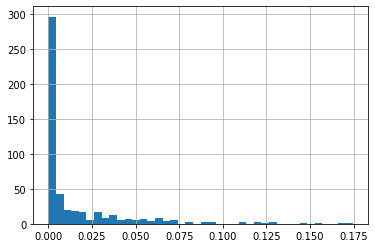

In [14]:
distances_s.hist(bins=40)